# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

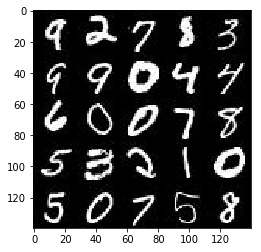

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

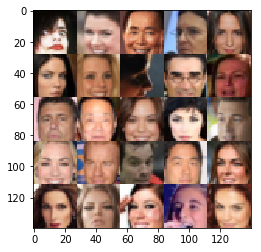

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0-rc2
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real_input, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/arthurcgusmao/.anaconda2/envs/tflearn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    i

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    depth1 = 32
    depth2 = 2*depth1
    depth3 = 2*depth2
    
    def leaky_relu(inp):
            return tf.maximum(inp, inp*alpha)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, depth1, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        l1 = leaky_relu(l1)
        
        l2 = tf.layers.conv2d(l1, depth2, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = leaky_relu(l2)
            
        l3 = tf.layers.conv2d(l2, depth3, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.nn.dropout(l3, 0.5)
        l3 = leaky_relu(l3)
        
        flatten = tf.reshape(l3, [-1, 4*4*depth3])
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    depth1 = 512
    depth2 = depth1 // 2
    depth3 = depth2 // 2
    
    def leaky_relu(inp):
            return tf.maximum(inp, inp*alpha)
        
    with tf.variable_scope('generator', reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*depth1)
        l1 = tf.reshape(l1, [-1, 7, 7, depth1])
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = leaky_relu(l1)
        # 7 x 7
        
        l2 = tf.layers.conv2d_transpose(l1, depth2, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = leaky_relu(l2)
        # 14 x 14
        
        l3 = tf.layers.conv2d_transpose(l2, depth3, 5, strides=1, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = leaky_relu(l3)
        # 14 x 14
        
        l4 = tf.layers.conv2d_transpose(l3, depth3, 5, strides=2, padding='same')
        l4 = tf.layers.batch_normalization(l4, training=is_train)
        l4 = tf.nn.dropout(l4, 0.5)
        l4 = leaky_relu(l4)
        # 28 x 28
        
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)
        # 28 x 28 x out_channel_dim
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, alpha=alpha)
    d_output_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            # using this smooth value (0.9) helps optimizing (see Review\ 1.pdf)
            labels=0.9*tf.ones_like(d_output_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_output_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    step = 0
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                step += 1
                
                # taking images from [-0.5, 0.5] range to [-1.0, 1.0] range
                batch_images = batch_images*2
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                feed = {real_input: batch_images, z: batch_z, lr: learning_rate}
                sess.run(d_train_opt, feed_dict=feed)
                sess.run(g_train_opt, feed_dict=feed)
                sess.run(g_train_opt, feed_dict=feed)
                # training the generator twice in comparison to the discriminator
                
                # print information every _ steps
                if step % print_every == 0:
                    train_loss_d = d_loss.eval(feed)
                    train_loss_g = g_loss.eval(feed)
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # show generated image samples every _ steps
                if step % show_every == 0:
                    show_generator_output(sess, 25, z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5630... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 2.6390... Generator Loss: 0.5434
Epoch 1/2... Discriminator Loss: 1.9341... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 0.9036
Epoch 1/2... Discriminator Loss: 1.8037... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 1.6873... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.8560... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.9614... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.8746
Epoch 1/2... Discriminator Loss: 1.7651... Generator Loss: 0.9100


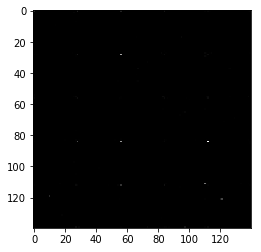

Epoch 1/2... Discriminator Loss: 1.7021... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.5304... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.7027
Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.6308... Generator Loss: 0.6498
Epoch 1/2... Discriminator Loss: 1.5870... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.5858... Generator Loss: 0.7406
Epoch 1/2... Discriminator Loss: 1.6703... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.6114... Generator Loss: 0.7519


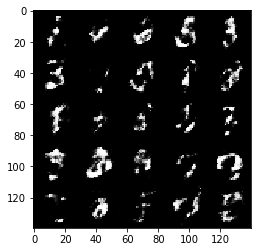

Epoch 1/2... Discriminator Loss: 1.5467... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.3663... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.8218
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.5023... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 1.5884... Generator Loss: 0.8564
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.5641... Generator Loss: 0.7826


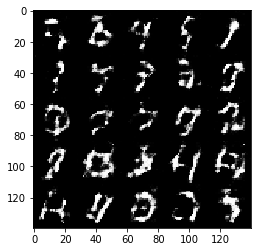

Epoch 1/2... Discriminator Loss: 1.4631... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.5122... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 1.5671... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 1.5125... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 0.7781
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 0.7624


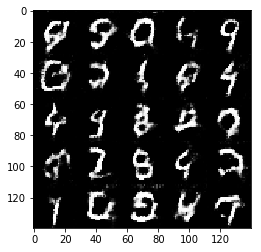

Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 1.4725... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.9224
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 0.7687


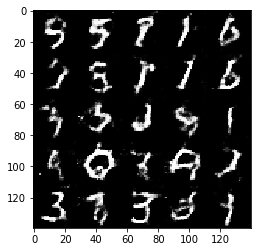

Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.5251... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.9005
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.8554
Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.8192


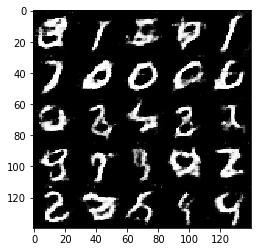

Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.7583
Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.7533
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.5101... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.8997


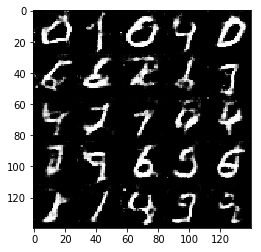

Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 1.4762... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.8380
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 0.7830


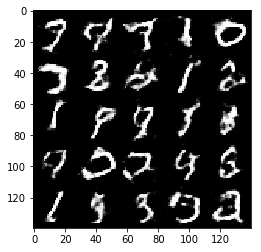

Epoch 1/2... Discriminator Loss: 1.4381... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.7530
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.7386


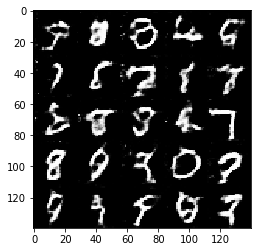

Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 1.4808... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.4467... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.4255... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.4969... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.4926... Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 1.4962... Generator Loss: 0.7303


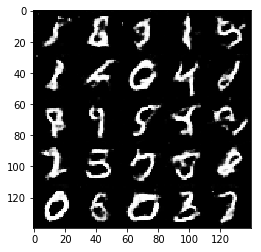

Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.4870... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.4949... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.4503... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.7650
Epoch 2/2... Discriminator Loss: 1.4676... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.8471


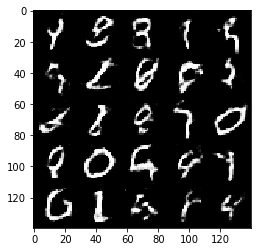

Epoch 2/2... Discriminator Loss: 1.4671... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.4845... Generator Loss: 0.7332
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.8458
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.4369... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.8581
Epoch 2/2... Discriminator Loss: 1.4943... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.7686


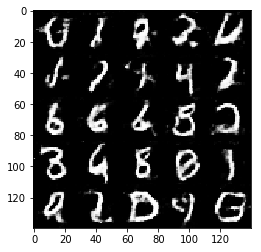

Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 1.4761... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 1.4082... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.7680
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.4400... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 1.4482... Generator Loss: 0.7256


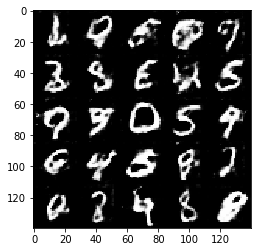

Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 1.5251... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.4552... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.4405... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.8428
Epoch 2/2... Discriminator Loss: 1.5246... Generator Loss: 0.6793


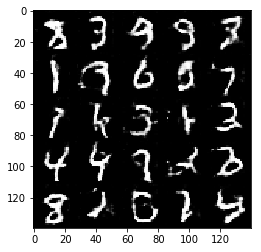

Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.8239
Epoch 2/2... Discriminator Loss: 1.4547... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.3636... Generator Loss: 0.8765
Epoch 2/2... Discriminator Loss: 1.4150... Generator Loss: 0.8214
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 1.0298
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.7600
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.7463
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.7769


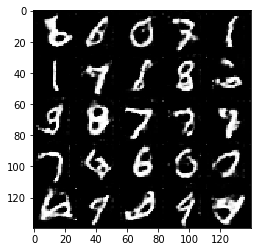

Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.7917
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.4595... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.9638
Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 0.7060
Epoch 2/2... Discriminator Loss: 1.4554... Generator Loss: 0.9217


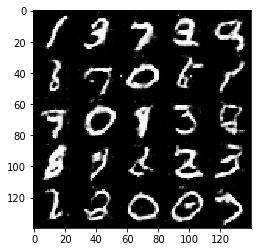

Epoch 2/2... Discriminator Loss: 1.4321... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.4661... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.4643... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.9225
Epoch 2/2... Discriminator Loss: 1.4139... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 0.6703


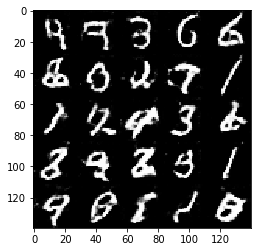

Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.4298... Generator Loss: 0.7372
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 1.4752... Generator Loss: 0.7221
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.6739


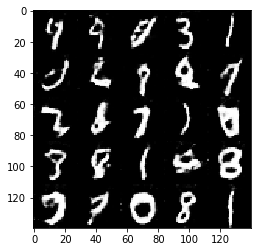

Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.4504... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.8118
Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.8621


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6149... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 2.2809... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.7164... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 1.3492


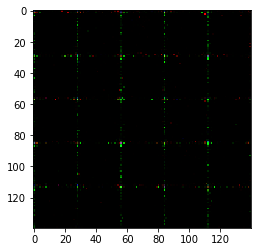

Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 1.0420


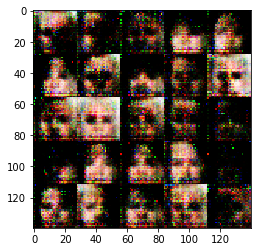

Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.6846... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.7743... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.8597... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.7381... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.8689... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.9476


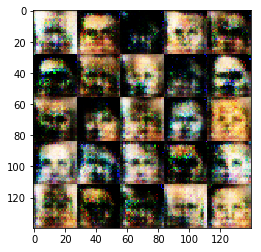

Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.8016... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.6346... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.6873... Generator Loss: 0.8311


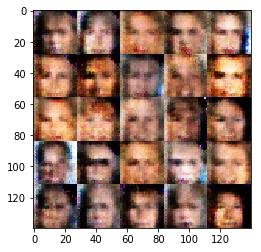

Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.7136... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.6417... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.6378... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.6521... Generator Loss: 0.8512


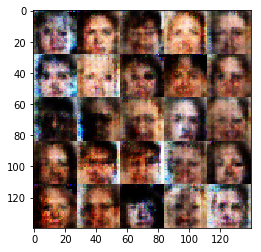

Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.8143


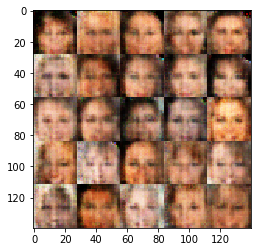

Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.7844


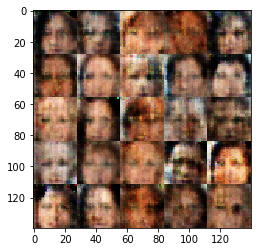

Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.7392


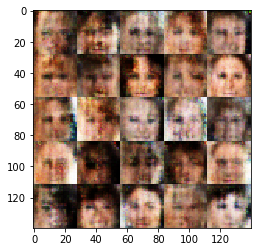

Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7830


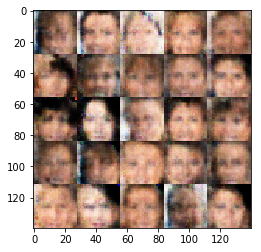

Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7287


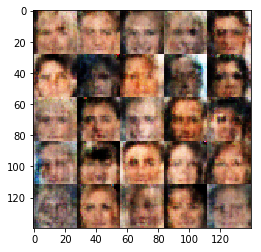

Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.7970


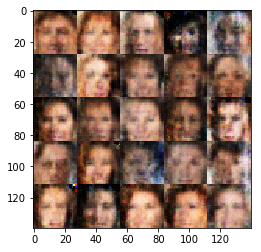

Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7801


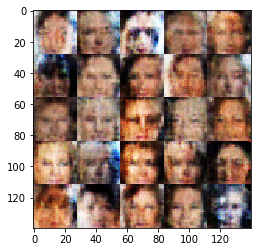

Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8018


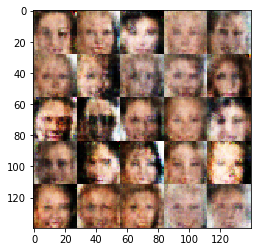

Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.8103


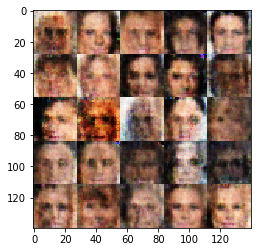

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7499


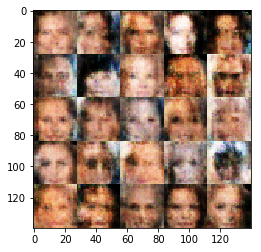

Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.8215


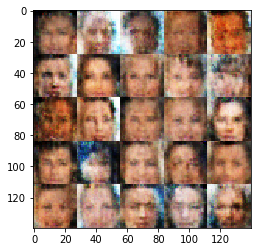

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7894


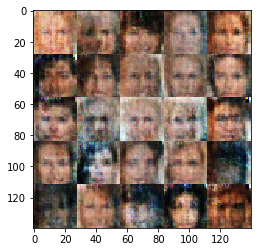

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8066


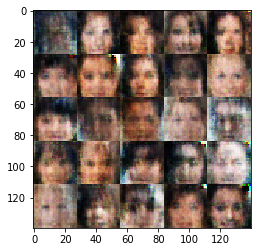

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7707


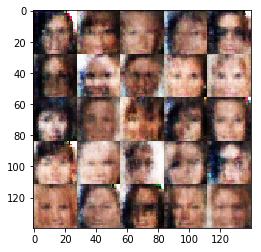

Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7819


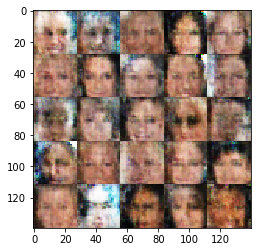

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8140


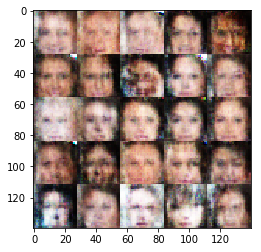

Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7796


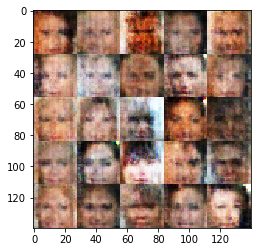

Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7638


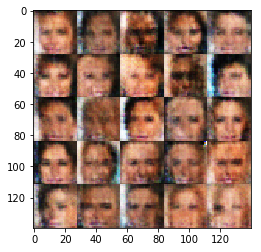

Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.8002


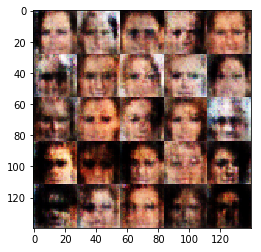

Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8188


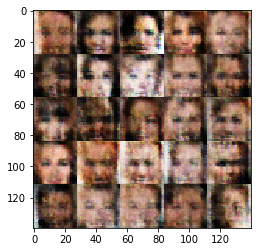

Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7809


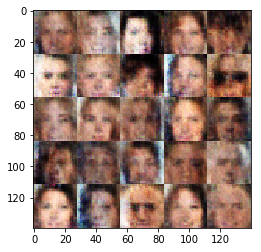

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7917


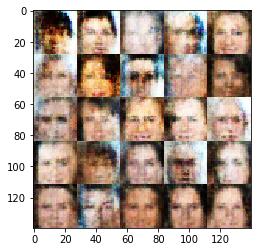

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8102


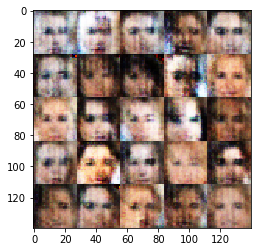

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7694


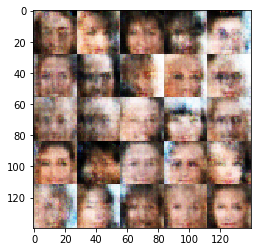

Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7830


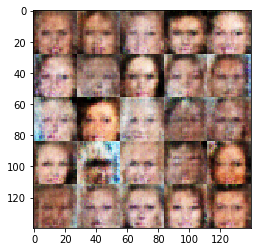

Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8061


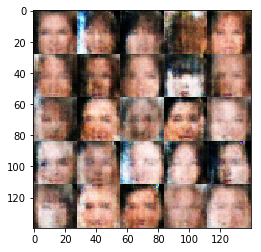

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8066


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.